In [2]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [12]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error


from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()

In [5]:
# esios_df = esios_provider.get_all_series(freq="H", start_index="2022-11-01 00:00", end_index="2023-02-28 23:59")
esios_df = esios_provider.get_all_series(freq="H", start_index="2023-02-01 00:00", end_index="2023-02-28 23:59")
esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand = esios_df["DEMANDA_REAL"]
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, esios_spot, test_size=24, shuffle=False)
regressor = RandomForestRegressor()

In [13]:
def compute_lag_df(y, window_length):
    lag_values = list(range(1, window_length+1))

    name = y.columns[0]
    for lag in lag_values:
        y[name+"_shift"+str(lag)] = y[name].shift(lag)

    y = y.drop(name, axis=1)
    return y

In [14]:
def compute_lag_fh_df(y, window_length, fh):
    return pd.concat([y.shift(fh-1),compute_lag_df(y, window_length)], axis=1)

In [15]:
def compute_ml_ts_data(y, X, window_length, fh, add_date=True, add_hour=True):
    y = pd.DataFrame(y)

    if add_date:
        X['year'] = y.index.year
        X['month'] = y.index.month
        X['day'] = y.index.day

    if add_hour:
        X['hour'] = y.index.hour
        df = pd.concat([compute_lag_fh_df(y, window_length, fh), X], axis=1)
        return df.dropna()

In [8]:
def compute_ml_X(y, X, window_length, add_date=True, add_hour=True):
    y = pd.DataFrame(y)

    if add_date:
        X['year'] = y.index.year
        X['month'] = y.index.month
        X['day'] = y.index.day
        X["day_of_week"] = y.index.dayofweek

    if add_hour:
        X['hour'] = y.index.hour

    df = pd.concat([compute_lag_df(y, window_length), X], axis=1)
    return df.dropna()

In [9]:
def train_forecaster_ml(y, X, window_length, fh, regressor, add_date=True, add_hour=True):
    X_ml = compute_ml_X(y, X, window_length, add_date, add_hour)
    X_train, X_test = train_test_split(X_ml, test_size=168, shuffle=False)

    y_test = np.zeros([fh])
    y_pred = np.zeros([fh])
    for horizon in range(0, fh):
        y_train, y_test_local = train_test_split(y.shift(horizon), test_size=168, shuffle=False)

        regressor.fit(X_train, y_train)
        y_pred_local = regressor.predict(X_test)
        y_pred_local = pd.DataFrame(y_pred_local).set_index(y_test.index)

        y_pred[horizon] = y_pred_local

    mape = mean_absolute_percentage_error(y_test, y_pred)


IndentationError: expected an indented block (3877047018.py, line 2)

In [16]:
ml_data = compute_ml_ts_data(esios_spot, X, 24, 1, add_date=True, add_hour=True)
X_train, X_test, y_train, y_test = train_test_split(ml_data.iloc[:, 1:], ml_data.iloc[:,0], test_size=168, shuffle=False)

In [17]:
regressor.fit(X_train, y_train)

RandomForestRegressor()

0.24863448206654268


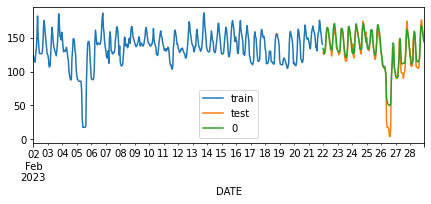

In [18]:
y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred).set_index(y_test.index)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

fig, ax = plt.subplots(figsize=(7, 2.5))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

Permutation explainer: 169it [00:56,  2.67it/s]                         


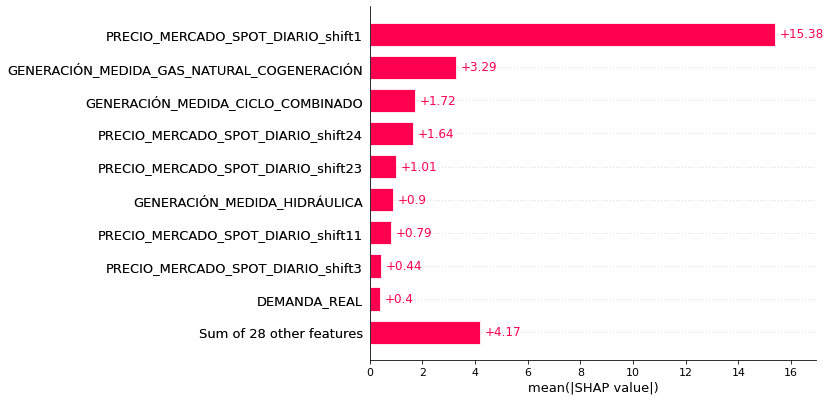

In [19]:
explainer = shap.Explainer(regressor.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [20]:
shap_values

.values =
array([[ 4.71360000e-01,  2.10737643e-01, -6.39541000e-01, ...,
         0.00000000e+00,  1.08317143e-02, -2.36811071e-01],
       [-5.25292879e+00,  2.82001286e-01, -5.71786000e-01, ...,
         0.00000000e+00, -2.52775714e-02, -2.78203000e-01],
       [-1.06854211e+01,  3.21282929e-01, -2.83038786e-01, ...,
         0.00000000e+00, -3.90674286e-02, -2.66173929e-01],
       ...,
       [ 1.73658329e+01, -5.03908571e-02, -1.85406929e-01, ...,
         0.00000000e+00,  5.27457143e-03,  2.79607857e-02],
       [ 1.58454689e+01, -5.32855857e-01, -1.71246000e-01, ...,
         0.00000000e+00, -4.41933571e-02,  4.02355714e-02],
       [ 1.14191244e+01, -7.83965214e-01, -3.04451071e-01, ...,
         0.00000000e+00,  3.65960000e-02,  1.47630929e-01]])

.base_values =
array([137.970777, 137.970777, 137.970777, 137.970777, 137.970777,
       137.970777, 137.970777, 137.970777, 137.970777, 137.970777,
       137.970777, 137.970777, 137.970777, 137.970777, 137.970777,
       137.97077

Permutation explainer: 169it [00:54,  2.57it/s]                         


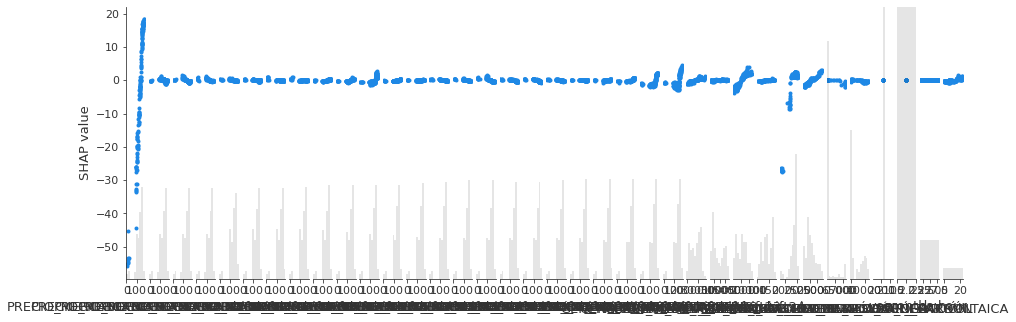

In [180]:
shap.plots.scatter(shap_values)

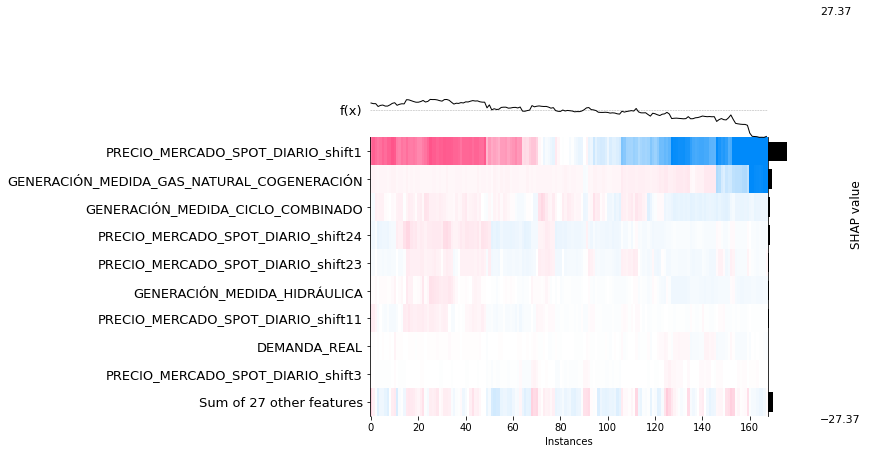

In [183]:
shap.plots.heatmap(shap_values)

In [5]:
train_window_size_list = [2, 5, 7, 14, 30]
train_window_size_list = [24*x for x in train_window_size_list]
forecasting_horizon = 24

cv_results_list = func.crossval_window_size_make_reduction(esios_spot, X, regressor, train_window_size_list, forecasting_horizon)

ValueError: The `window_length` and `fh` are incompatible with the length of `y`

In [8]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
#y_pred = forecaster.predict(fh=fh, X=X_test)

RandomForestRegressor()

In [78]:
explainer = shap.Explainer(regressor.predict, X_test)

In [79]:
shap_values = explainer(X_test)

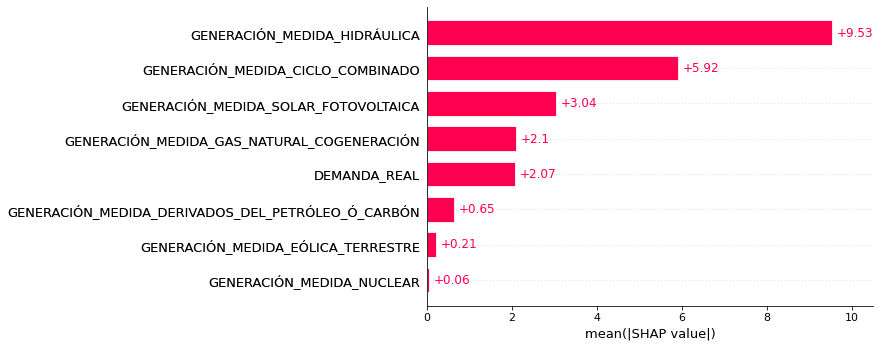

In [80]:
shap.plots.bar(shap_values)